<a href="https://colab.research.google.com/github/HeTalksInMaths/DeepMLProj-OEIS/blob/main/Deep_Learning_Project_OEIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fixed Time-Step Numerical Sequence Learning

# Project Overiew


Recurrent neural networks (RNNs) are regularly used in sequence learning (both text and numerical)to predict subsequent words or values based on prior words or values. However, predicting values for a pre-specified time-step may benefit from additional information relevant to the time-step in question. Some real-world examples may be determining stock prices 100 days after an IPO or final booking occupancy for a hotel on a specific date based on existing bookings 10 days prior. 
 
In these examples it is unclear whether stock price fluctuations or stay date booking curve projections can be modeled as samples drawn from some complex underlying joint distribution, where fitting on a subset would lead to generalizability to other instances. If indeed this was the case, a rich data set with a large sample size would likely be required.
 
The Online Encyclopedia of Integer Sequences (OEIS)consists of sequences from various unrelated branches of mathematics, and furthermore a significantly reduced partially randomized subset is studied to further reduce the likelihood of generalizability across sequences. Even with these restrictions,fitting models towards a fixed time-step in the integer sequence may be beneficial.   
 
Two approaches will be considered here with the aim of learning the 10th sequence value in this set of OEIS sequences. Firstly a training subset will be fitted towards the 10th sequence value and inference made on different sequences. Secondly all sequences are used and fitting on earlier sequence values will be used with inference towards the 10th sequence value in particular.  Validation sets in both instances are appropriately constructed to avoid overfitting and ensure generalizability. This will help further understand how strongly subsets of sequences within OEIS are related to one another and if there is inherent structure across them.
 
The github repository link for this work is located here: https://github.com/HeTalksInMaths/DeepMLProj-OEIS


# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns

# Loading Data

The data comes from the Online Encyclopedia of Integer Sequences https://oeis.org/ (Sloane, 1964). This notebook is self-contained and the data is downloaded from a public Google Drive folder. Files were originally downloaed from https://davidbieber.com/snippets/2020-06-28-oeis-download/ (Bieber, 2020).

In [2]:
fileid='1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip'
filename='oeis.csv'

!wget -O $filename 'https://docs.google.com/uc?export=download&id='$fileid

--2022-12-07 01:49:40--  https://docs.google.com/uc?export=download&id=1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip
Resolving docs.google.com (docs.google.com)... 172.253.117.138, 172.253.117.139, 172.253.117.102, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t3uv4q1si8b4a4oubep5shn6qv043kr9/1670377725000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=bc9f1a20-5de2-4baa-b57a-a9bf69bd5585 [following]
--2022-12-07 01:49:44--  https://doc-0o-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t3uv4q1si8b4a4oubep5shn6qv043kr9/1670377725000/02208792382482262317/*/1cD9NbA40x9Nu8k2F7pSr3aKhS0VASfip?e=download&uuid=bc9f1a20-5de2-4baa-b57a-a9bf69bd5585
Resolving doc-0o-4k-docs.googleusercontent.com (doc-0o-4k-docs.googleusercontent.com)... 74.125.135.132, 2607:f

Sequences are of varying lengths but for our purposes only the first 10 sequence values are used. The below code extracts these values.

In [3]:
dfseq = pd.read_csv('/content/oeis.csv', header=None, skiprows=4, usecols=range(11), names=["Sequence", 
                                                                                                        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

for c in dfseq.columns[1:]:
  dfseq[c] = pd.to_numeric(dfseq[c], errors='coerce', downcast="integer")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory Data Analysis (EDA)

In [4]:
dfseq.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
0,A000001,0.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,5.0,2.0
1,A000002,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0
2,A000003,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0
3,A000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A000005,1.0,2.0,2.0,3.0,2.0,4.0,2.0,4.0,3.0,4.0


In [5]:
dfseq.shape

(351519, 11)

350,000+ sequences are in the full dataset but some contain missing values.

In [6]:
dfseq.dropna(axis=0, inplace = True)
dfseq.shape

(330583, 11)

In [7]:
np.max(dfseq.select_dtypes(include=np.number), axis = 0)

1     1.111111e+127
2      3.402824e+38
3      1.000000e+63
4      2.975857e+79
5     9.046413e+110
6      5.555556e+70
7     2.222222e+205
8     1.307539e+167
9      3.187368e+96
10    8.855667e+163
dtype: float64

In [8]:
np.mean(dfseq.select_dtypes(include=np.number), axis = 0)

1     3.734517e+121
2      1.029400e+33
3      6.049918e+57
4      9.002553e+73
5     2.736503e+105
6      1.680533e+65
7     6.722131e+199
8     3.955251e+161
9      9.641659e+90
10    2.678803e+158
dtype: float64

In [9]:
np.median(dfseq.select_dtypes(include=np.number), axis = 0)

array([  1.,   3.,   6.,  12.,  21.,  33.,  55.,  83., 119., 152.])


Notice the large max values which skew the means. The median values highlight the significant skew.  These large values are not ideal for neural network learning and may dominate weight learning, leading to poor generalizability.  

A manageable reduced set of sequences with values between 0 and 100 inclusive is instead used.

In [10]:
dfseq_red = dfseq[(dfseq[dfseq.columns[1:11]] <= 100).sum(1) > 9]
dfseq_red = dfseq_red[(dfseq_red[dfseq_red.columns[1:11]] >= 0).sum(1) > 9]

In [11]:
dfseq_red.shape

(137892, 11)

Almost 140,000 sequences still remain.

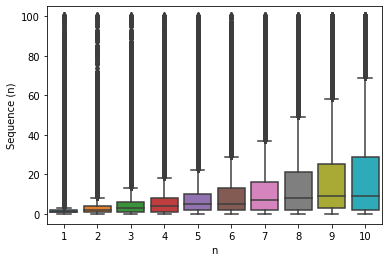

In [12]:
dfseq_red_long = dfseq_red.melt(id_vars = ['Sequence'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x=dfseq_red_long["n"], y=dfseq_red_long["Sequence (n)"] );
plt.show()

The boxplot above still highlights skew even with the amenable maximum values. Some apparent structure of increasing medians across sequences appears to exist. However, there is no reason to believe all sequences are increasing even if this is the case on aggregate.

 
From these 140,000 sequences, 1,000 are sampled which is less than 1%. This should further undermine reasons to believe that the sequences are strongly related to one another.


In [13]:
dfseq_1000 = dfseq_red.sample(1000, random_state=0)

In [14]:
dfseq_1000.shape

(1000, 11)

In [15]:
dfseq_1000.head()

,Sequence,1,2,3,4,5,6,7,8,9,10
206739,A206740,1.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,9.0,13.0
253080,A253081,1.0,3.0,5.0,8.0,10.0,14.0,17.0,22.0,24.0,28.0
76987,A076988,2.0,3.0,13.0,5.0,21.0,13.0,8.0,89.0,55.0,21.0
65433,A065434,2.0,1.0,0.0,2.0,2.0,0.0,3.0,9.0,6.0,3.0
26475,A026476,1.0,3.0,4.0,9.0,12.0,23.0,26.0,37.0,40.0,51.0


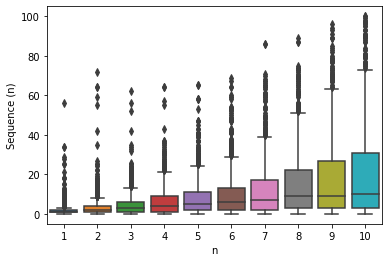

In [16]:
dfseq_1000_long = dfseq_1000.melt(id_vars = ['Sequence'], value_vars= ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
                        var_name='n', value_name='Sequence (n)')

sns.boxplot( x=dfseq_1000_long["n"], y=dfseq_1000_long["Sequence (n)"] );
plt.show()

Even with 1,000 sequences the boxplot above is quite similar to the one on nearly 140,000 sequence data set with on aggregate increasing medians across sequence values and skew. 

In [17]:
np.mean(dfseq_red.select_dtypes(include=np.number))

1      2.044390
2      3.241943
3      4.664962
4      6.194616
5      7.935711
6      9.499384
7     11.746947
8     14.303187
9     16.718787
10    19.064971
dtype: float64

In [18]:
np.median(np.array(dfseq_red.select_dtypes(include=np.number)), axis = 0)

array([1., 2., 3., 4., 5., 5., 7., 8., 9., 9.])

In [19]:
np.mean(dfseq_1000.select_dtypes(include=np.number))

1      1.856
2      3.426
3      4.708
4      6.359
5      8.190
6     10.004
7     12.256
8     15.241
9     17.607
10    20.174
dtype: float64

In [68]:
np.median(np.array(dfseq_1000.select_dtypes(include=np.number)), axis = 0)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9.,  9., 10.])

 
The above highlights similar patterns in mean and median values for the sampled data set and the larger one suggesting it is somewhat representative.


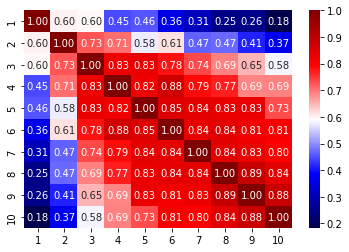

In [21]:
ax = sns.heatmap(dfseq_1000.corr(), annot = True, fmt = '.2f', cmap = 'seismic')
ax

The correlation matrix reinforces more clearly what is suspected from the boxplot. Correlations are stronger near the diagonals where consecutive or close in position sequence values are studied.  It is unclear which of the two methods we are considering will lead to better results but earlier parts of the sequence should be informative in predicting later parts. 

 The data matrix of the first nine sequence values and targets of tenth sequence values are converted to numpy arrays. This is most appropriate for the first method (details to follow) but can easily be manipulated for the second one as well.


In [22]:
X = np.array(dfseq_1000.drop(columns = ['Sequence', '10']))
y = np.array(dfseq_1000['10'])

# Experimental Setup

 
 
The first method involves splitting the 1000 sequences into a train:validation:test ratio of 7:2:1. On the training data the first nine sequence values will be used to learn the tenth sequence value. 
 
The second method will use all 1000 sequences for training but earlier parts of the sequences. In training the first seven sequence values will be used to learn the 8th with validation using the first eight sequence values to learn the 9th. Thus in the second method the generalization within sequences as opposed to across sequences is emphasized.
 
The test set will consist of only the 100 sequences identified in the first method so that comparisons can be made regarding effectiveness of the competing approaches.
 
The train test split procedure is used twice in the code below to give a split of 700-200-100 sequences for training, validation and testing for the first method.



In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0) # random_state set for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=2/9, random_state=0) # 2/9 x 0.9 = 0.2

In [25]:
X_train.shape

(700, 9)

In [26]:
np.mean(X_train, axis = 0)

array([ 1.94      ,  3.47857143,  4.98      ,  6.5       ,  8.46857143,
       10.24857143, 12.45428571, 15.32428571, 17.70142857])

In [27]:
np.mean(y_train)

20.338571428571427

#Method 1 Hyperparameter Tuning


Simple RNNs are favored as opposed to LSTMs or GRUs as sequences are short and we shouldn't have to worry about vanishing or exploding gradients in long sequences. We tune the number of RNN units as a hyperparameter with the following numbers of units considered: 10, 20, 50, 100, 200, 500. The Keras implementation used here has default tanh activations to learn non-linear relationships  and fully connects the outputs of the individual RNN units leading to more than $n^2$ parameters for $n$ units.
For larger numbers of units this highlights the importance of validation sets to avoid overfitting. Early-stopping with a patience of 10 is utilized so that if the loss on the validation set does not improve after 10 epochs, training halts with weights restored to ones that lead to optimal validation loss. Backpropagation via mean absolute error loss updates the weights with Adam used as the optimizer.  


In [29]:
np.random.seed(0)         # To ensure reproducibility. 
tf.random.set_seed(0)

model1 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1]), # None in input shape allows for variable length inputs
    keras.layers.Dense(1)
])
 
callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model1.compile(loss="mae", optimizer="adam")
history1 = model1.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 1s 16ms/step - loss: 21.1917 - val_loss: 20.9546
Epoch 2/500
22/22 [==============================] - 0s 4ms/step - loss: 20.7927 - val_loss: 20.5813
Epoch 3/500
22/22 [==============================] - 0s 5ms/step - loss: 20.4300 - val_loss: 20.2467
Epoch 4/500
22/22 [==============================] - 0s 5ms/step - loss: 20.0960 - val_loss: 19.9359
Epoch 5/500
22/22 [==============================] - 0s 5ms/step - loss: 19.8017 - val_loss: 19.6510
Epoch 6/500
22/22 [==============================] - 0s 4ms/step - loss: 19.5288 - val_loss: 19.3926
Epoch 7/500
22/22 [==============================] - 0s 5ms/step - loss: 19.3027 - val_loss: 19.1781
Epoch 8/500
22/22 [==============================] - 0s 5ms/step - loss: 19.1084 - val_loss: 18.9816
Epoch 9/500
22/22 [==============================] - 0s 4ms/step - loss: 18.9201 - val_loss: 18.7835
Epoch 10/500
22/22 [==============================] - 0s 5ms/step - loss: 18.7286 - val_lo

In [30]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


As mentioned earlier, with 10 RNN units, over 100 parameters are learned.

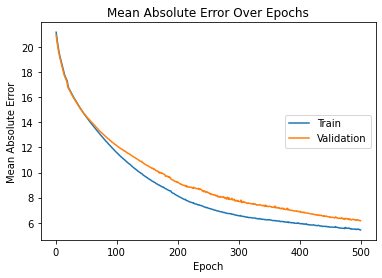

In [31]:
plt.plot(range(1,len(history1.history['loss']) + 1), history1.history['loss'])
plt.plot(range(1, len(history1.history['loss']) + 1) , history1.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

Here early stopping did not lead to training ending prematurely. More units are utilized instead for faster training.

In [32]:
np.random.seed(0)
tf.random.set_seed(0)

model2 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model2.compile(loss="mae", optimizer="adam")
history2 = model2.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 1s 14ms/step - loss: 19.5647 - val_loss: 19.2126
Epoch 2/500
22/22 [==============================] - 0s 4ms/step - loss: 18.9819 - val_loss: 18.7239
Epoch 3/500
22/22 [==============================] - 0s 4ms/step - loss: 18.5740 - val_loss: 18.3783
Epoch 4/500
22/22 [==============================] - 0s 4ms/step - loss: 18.2628 - val_loss: 18.0751
Epoch 5/500
22/22 [==============================] - 0s 4ms/step - loss: 17.9809 - val_loss: 17.8168
Epoch 6/500
22/22 [==============================] - 0s 4ms/step - loss: 17.7365 - val_loss: 17.5882
Epoch 7/500
22/22 [==============================] - 0s 4ms/step - loss: 17.5064 - val_loss: 17.3761
Epoch 8/500
22/22 [==============================] - 0s 4ms/step - loss: 17.2951 - val_loss: 17.1722
Epoch 9/500
22/22 [==============================] - 0s 4ms/step - loss: 17.0936 - val_loss: 16.9583
Epoch 10/500
22/22 [==============================] - 0s 5ms/step - loss: 16.8913 - val_lo

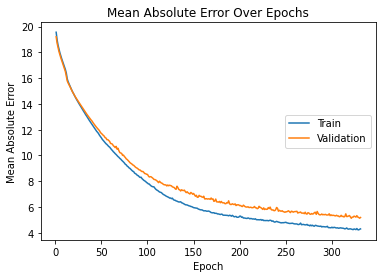

In [33]:
plt.plot(range(1,len(history2.history['loss']) + 1), history2.history['loss'])
plt.plot(range(1, len(history2.history['loss']) + 1) , history2.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

This time early stopping does lead to training stopping before 500 epochs.

In [34]:
np.random.seed(0)
tf.random.set_seed(0)

model3 = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model3.compile(loss="mae", optimizer="adam")
history3 = model3.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 1s 14ms/step - loss: 19.1486 - val_loss: 18.3104
Epoch 2/500
22/22 [==============================] - 0s 5ms/step - loss: 17.9787 - val_loss: 17.4676
Epoch 3/500
22/22 [==============================] - 0s 5ms/step - loss: 17.1313 - val_loss: 16.6057
Epoch 4/500
22/22 [==============================] - 0s 5ms/step - loss: 16.2626 - val_loss: 15.7950
Epoch 5/500
22/22 [==============================] - 0s 5ms/step - loss: 15.5718 - val_loss: 15.3224
Epoch 6/500
22/22 [==============================] - 0s 5ms/step - loss: 15.0559 - val_loss: 14.9180
Epoch 7/500
22/22 [==============================] - 0s 6ms/step - loss: 14.6211 - val_loss: 14.5355
Epoch 8/500
22/22 [==============================] - 0s 5ms/step - loss: 14.2310 - val_loss: 14.2401
Epoch 9/500
22/22 [==============================] - 0s 5ms/step - loss: 13.9068 - val_loss: 13.9621
Epoch 10/500
22/22 [==============================] - 0s 5ms/step - loss: 13.5704 - val_lo

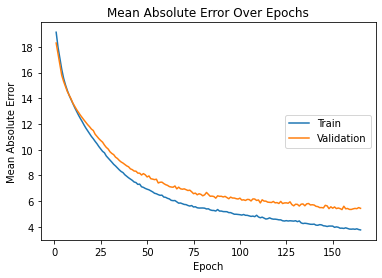

In [35]:
plt.plot(range(1,len(history3.history['loss']) + 1), history3.history['loss'])
plt.plot(range(1, len(history3.history['loss']) + 1) , history3.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [36]:
np.random.seed(0)
tf.random.set_seed(0)

model4 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model4.compile(loss="mae", optimizer="adam")
history4 = model4.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 1s 15ms/step - loss: 18.2212 - val_loss: 16.5893
Epoch 2/500
22/22 [==============================] - 0s 6ms/step - loss: 15.9202 - val_loss: 15.3386
Epoch 3/500
22/22 [==============================] - 0s 6ms/step - loss: 14.6571 - val_loss: 14.2330
Epoch 4/500
22/22 [==============================] - 0s 6ms/step - loss: 13.6787 - val_loss: 13.5106
Epoch 5/500
22/22 [==============================] - 0s 6ms/step - loss: 12.9683 - val_loss: 12.9727
Epoch 6/500
22/22 [==============================] - 0s 6ms/step - loss: 12.3375 - val_loss: 12.4816
Epoch 7/500
22/22 [==============================] - 0s 7ms/step - loss: 11.8026 - val_loss: 12.0816
Epoch 8/500
22/22 [==============================] - 0s 6ms/step - loss: 11.3077 - val_loss: 11.6555
Epoch 9/500
22/22 [==============================] - 0s 6ms/step - loss: 10.9029 - val_loss: 11.3041
Epoch 10/500
22/22 [==============================] - 0s 6ms/step - loss: 10.5087 - val_lo

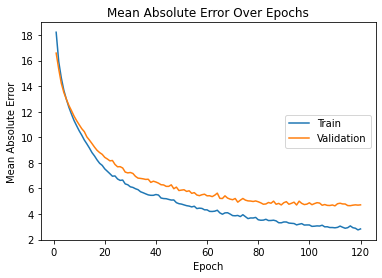

In [37]:
plt.plot(range(1,len(history4.history['loss']) + 1), history4.history['loss'])
plt.plot(range(1, len(history4.history['loss']) + 1) , history4.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [38]:
np.random.seed(0)
tf.random.set_seed(0)

model5 = keras.models.Sequential([
    keras.layers.SimpleRNN(200, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model5.compile(loss="mae", optimizer="adam")
history5 = model5.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 1s 17ms/step - loss: 16.2839 - val_loss: 14.3379
Epoch 2/500
22/22 [==============================] - 0s 8ms/step - loss: 13.2860 - val_loss: 12.8871
Epoch 3/500
22/22 [==============================] - 0s 9ms/step - loss: 11.8642 - val_loss: 11.8496
Epoch 4/500
22/22 [==============================] - 0s 9ms/step - loss: 10.7545 - val_loss: 10.9542
Epoch 5/500
22/22 [==============================] - 0s 8ms/step - loss: 10.0547 - val_loss: 10.2827
Epoch 6/500
22/22 [==============================] - 0s 8ms/step - loss: 9.3210 - val_loss: 9.7821
Epoch 7/500
22/22 [==============================] - 0s 8ms/step - loss: 8.8027 - val_loss: 9.4129
Epoch 8/500
22/22 [==============================] - 0s 8ms/step - loss: 8.2202 - val_loss: 8.7850
Epoch 9/500
22/22 [==============================] - 0s 8ms/step - loss: 7.8096 - val_loss: 8.4222
Epoch 10/500
22/22 [==============================] - 0s 8ms/step - loss: 7.3903 - val_loss: 8.092

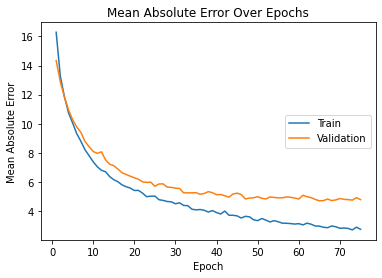

In [39]:
plt.plot(range(1,len(history5.history['loss']) + 1), history5.history['loss'])
plt.plot(range(1, len(history5.history['loss']) + 1) , history5.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [40]:
np.random.seed(0)
tf.random.set_seed(0)

model6 = keras.models.Sequential([
    keras.layers.SimpleRNN(500, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model6.compile(loss="mae", optimizer="adam")
history6 = model6.fit(X_train, y_train, epochs=500, callbacks = [callback],
                    validation_data=(X_val, y_val))

Epoch 1/500
22/22 [==============================] - 2s 38ms/step - loss: 12.9841 - val_loss: 10.8583
Epoch 2/500
22/22 [==============================] - 1s 28ms/step - loss: 9.3716 - val_loss: 9.2368
Epoch 3/500
22/22 [==============================] - 1s 29ms/step - loss: 7.8636 - val_loss: 8.2897
Epoch 4/500
22/22 [==============================] - 1s 28ms/step - loss: 7.1956 - val_loss: 7.7626
Epoch 5/500
22/22 [==============================] - 1s 28ms/step - loss: 6.6521 - val_loss: 7.3111
Epoch 6/500
22/22 [==============================] - 1s 29ms/step - loss: 6.2806 - val_loss: 7.2034
Epoch 7/500
22/22 [==============================] - 1s 28ms/step - loss: 6.1291 - val_loss: 7.1553
Epoch 8/500
22/22 [==============================] - 1s 28ms/step - loss: 6.1187 - val_loss: 6.9223
Epoch 9/500
22/22 [==============================] - 1s 29ms/step - loss: 5.9586 - val_loss: 6.4960
Epoch 10/500
22/22 [==============================] - 1s 28ms/step - loss: 5.6738 - val_loss: 6.10

In [45]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 500)               251000    
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


With 500 RNN units, the number of parameters is over $500^2$ which leads to faster but less stable training as can be seen in the loss curves for training and validation sets below. 

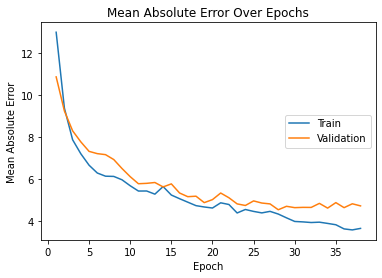

In [41]:
plt.plot(range(1,len(history6.history['loss']) + 1), history6.history['loss'])
plt.plot(range(1, len(history6.history['loss']) + 1) , history6.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

Now we compare the loss across models.

In [42]:
models = [model1, model2, model3, model4, model5, model6]
maes_train = []
maes_val = []

for model in models:
  preds_train = model.predict(X_train)
  preds_val = model.predict(X_val)
  maes_train.append(np.mean(abs(preds_train[:,0] - y_train)))
  maes_val.append(np.mean(abs(preds_val[:,0] - y_val)))

7/7 [==============================] - 0s 8ms/step


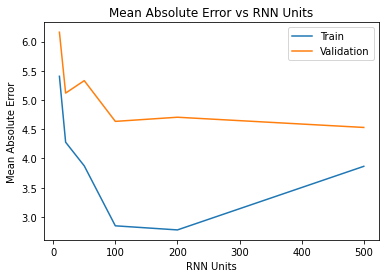

In [43]:
units = [10,20,50,100,200,500]

plt.plot(units, maes_train)
plt.plot(units , maes_val)
plt.title('Mean Absolute Error vs RNN Units')
plt.ylabel('Mean Absolute Error')
plt.xlabel('RNN Units')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [44]:
maes_val

[6.160511969327927,
 5.118888597488404,
 5.332018581330776,
 4.634546124041081,
 4.705581966489554,
 4.530766005143523]

|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|6.161|
|20|5.119|
|50|5.332|
|100|4.635|
|200|4.706|
|500|4.531|

The above table summarizes the results to four significant figures. 500 RNN units leads to the lowest mean absolute error on the 200 sequences in the validation data set though there is not much improvement between 100, 200 and 500 sequences. 

In [46]:
preds = model6.predict(X_test)
np.mean(abs(preds[:,0] - y_test))

4/4 [==============================] - 0s 9ms/step


3.440325720086694

The 500 RNN unit model for method 1 leads to a mean absolute error of 3.440 (4 s.f.) on the 100 sequences in the test set when predicting the 10th sequence value using the prior nine. This is better than the errors in training and validation sets suggesting good generalizability of the model used. We will compare this to method 2 later.


In [47]:
np.mean(preds[:,0] - y_test)

-0.885579257979989

The above calculation shows that the model slightly underpredicted on average the 10th sequence value.

# Method 2 Hyperparameter Tuning


Now we move on to fitting and hyperparameter tuning with the second method. The model architecture considerations are identical to those in the first method to emphasize the effect of change in the experimental procedure. The various numbers of RNN units tried will be the same as before but the data used to fit and validate are different (see comments in code below).


In [48]:
np.random.seed(0)
tf.random.set_seed(0)

model7 = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model7.compile(loss="mae", optimizer="adam")
history7 = model7.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback], # Note the data used for fitting and validation.
                    validation_data=(X[:,:8], X[:,8]))                     # All 1000 sequences used but fit on earlier
                                                                           # sequence values. 

Epoch 1/500
32/32 [==============================] - 1s 12ms/step - loss: 16.0915 - val_loss: 18.0744
Epoch 2/500
32/32 [==============================] - 0s 5ms/step - loss: 15.5206 - val_loss: 17.5614
Epoch 3/500
32/32 [==============================] - 0s 5ms/step - loss: 15.0081 - val_loss: 17.1122
Epoch 4/500
32/32 [==============================] - 0s 5ms/step - loss: 14.5653 - val_loss: 16.7043
Epoch 5/500
32/32 [==============================] - 0s 5ms/step - loss: 14.1883 - val_loss: 16.3739
Epoch 6/500
32/32 [==============================] - 0s 6ms/step - loss: 13.8747 - val_loss: 16.0747
Epoch 7/500
32/32 [==============================] - 0s 5ms/step - loss: 13.5804 - val_loss: 15.7771
Epoch 8/500
32/32 [==============================] - 0s 5ms/step - loss: 13.2906 - val_loss: 15.4928
Epoch 9/500
32/32 [==============================] - 0s 5ms/step - loss: 13.0130 - val_loss: 15.1995
Epoch 10/500
32/32 [==============================] - 0s 5ms/step - loss: 12.7478 - val_lo

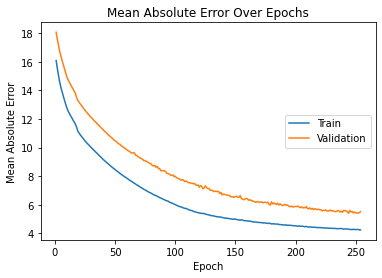

In [49]:
plt.plot(range(1,len(history7.history['loss']) + 1), history7.history['loss'])
plt.plot(range(1, len(history7.history['loss']) + 1) , history7.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [50]:
np.random.seed(0)
tf.random.set_seed(0)

model8 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model8.compile(loss="mae", optimizer="adam")
history8 = model8.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

Epoch 1/500
32/32 [==============================] - 1s 16ms/step - loss: 14.4064 - val_loss: 16.2630
Epoch 2/500
32/32 [==============================] - 0s 11ms/step - loss: 13.6450 - val_loss: 15.6946
Epoch 3/500
32/32 [==============================] - 0s 6ms/step - loss: 13.1753 - val_loss: 15.2627
Epoch 4/500
32/32 [==============================] - 1s 20ms/step - loss: 12.7616 - val_loss: 14.8778
Epoch 5/500
32/32 [==============================] - 1s 16ms/step - loss: 12.3785 - val_loss: 14.4968
Epoch 6/500
32/32 [==============================] - 0s 11ms/step - loss: 11.9262 - val_loss: 13.9469
Epoch 7/500
32/32 [==============================] - 0s 9ms/step - loss: 11.4978 - val_loss: 13.6006
Epoch 8/500
32/32 [==============================] - 0s 15ms/step - loss: 11.1074 - val_loss: 13.1229
Epoch 9/500
32/32 [==============================] - 0s 10ms/step - loss: 10.7563 - val_loss: 12.8740
Epoch 10/500
32/32 [==============================] - 0s 5ms/step - loss: 10.5357 - 

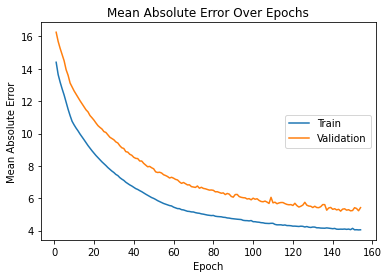

In [51]:
plt.plot(range(1,len(history8.history['loss']) + 1), history8.history['loss'])
plt.plot(range(1, len(history8.history['loss']) + 1) , history8.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [52]:
np.random.seed(0)
tf.random.set_seed(0)

model9 = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model9.compile(loss="mae", optimizer="adam")
history9 = model9.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

Epoch 1/500
32/32 [==============================] - 2s 11ms/step - loss: 13.7014 - val_loss: 15.1047
Epoch 2/500
32/32 [==============================] - 0s 5ms/step - loss: 12.0440 - val_loss: 13.7067
Epoch 3/500
32/32 [==============================] - 0s 6ms/step - loss: 10.8676 - val_loss: 12.7283
Epoch 4/500
32/32 [==============================] - 0s 6ms/step - loss: 10.1239 - val_loss: 11.9733
Epoch 5/500
32/32 [==============================] - 0s 6ms/step - loss: 9.5432 - val_loss: 11.4116
Epoch 6/500
32/32 [==============================] - 0s 5ms/step - loss: 9.0593 - val_loss: 10.9487
Epoch 7/500
32/32 [==============================] - 0s 6ms/step - loss: 8.6556 - val_loss: 10.5042
Epoch 8/500
32/32 [==============================] - 0s 5ms/step - loss: 8.3180 - val_loss: 10.1382
Epoch 9/500
32/32 [==============================] - 0s 7ms/step - loss: 8.0052 - val_loss: 9.8272
Epoch 10/500
32/32 [==============================] - 0s 5ms/step - loss: 7.7370 - val_loss: 9.5

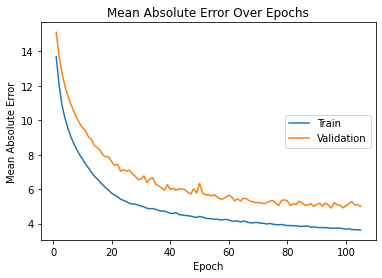

In [53]:
plt.plot(range(1,len(history9.history['loss']) + 1), history9.history['loss'])
plt.plot(range(1, len(history9.history['loss']) + 1) , history9.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [54]:
np.random.seed(0)
tf.random.set_seed(0)

model10 = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model10.compile(loss="mae", optimizer="adam")
history10 = model10.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

Epoch 1/500
32/32 [==============================] - 1s 13ms/step - loss: 12.3786 - val_loss: 12.9620
Epoch 2/500
32/32 [==============================] - 0s 7ms/step - loss: 9.9113 - val_loss: 11.4502
Epoch 3/500
32/32 [==============================] - 0s 6ms/step - loss: 8.7682 - val_loss: 10.3109
Epoch 4/500
32/32 [==============================] - 0s 6ms/step - loss: 7.9762 - val_loss: 9.5979
Epoch 5/500
32/32 [==============================] - 0s 6ms/step - loss: 7.4027 - val_loss: 8.9608
Epoch 6/500
32/32 [==============================] - 0s 9ms/step - loss: 6.9432 - val_loss: 8.6989
Epoch 7/500
32/32 [==============================] - 0s 6ms/step - loss: 6.6342 - val_loss: 8.0912
Epoch 8/500
32/32 [==============================] - 0s 6ms/step - loss: 6.1831 - val_loss: 7.6865
Epoch 9/500
32/32 [==============================] - 0s 6ms/step - loss: 5.8587 - val_loss: 7.5220
Epoch 10/500
32/32 [==============================] - 0s 6ms/step - loss: 5.5822 - val_loss: 7.1411
Epoc

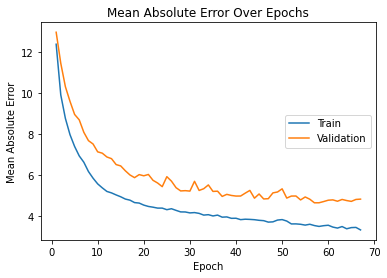

In [55]:
plt.plot(range(1,len(history10.history['loss']) + 1), history10.history['loss'])
plt.plot(range(1, len(history10.history['loss']) + 1) , history10.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [56]:
np.random.seed(0)
tf.random.set_seed(0)

model11 = keras.models.Sequential([
    keras.layers.SimpleRNN(200, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model11.compile(loss="mae", optimizer="adam")
history11 = model11.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

Epoch 1/500
32/32 [==============================] - 1s 14ms/step - loss: 10.4142 - val_loss: 10.6603
Epoch 2/500
32/32 [==============================] - 0s 9ms/step - loss: 7.6873 - val_loss: 8.7847
Epoch 3/500
32/32 [==============================] - 0s 8ms/step - loss: 6.5541 - val_loss: 7.7387
Epoch 4/500
32/32 [==============================] - 0s 11ms/step - loss: 5.8575 - val_loss: 7.2275
Epoch 5/500
32/32 [==============================] - 0s 8ms/step - loss: 5.4538 - val_loss: 6.6396
Epoch 6/500
32/32 [==============================] - 0s 10ms/step - loss: 5.2105 - val_loss: 6.3291
Epoch 7/500
32/32 [==============================] - 0s 8ms/step - loss: 5.1078 - val_loss: 6.0536
Epoch 8/500
32/32 [==============================] - 0s 11ms/step - loss: 4.8901 - val_loss: 5.9121
Epoch 9/500
32/32 [==============================] - 0s 8ms/step - loss: 4.9040 - val_loss: 6.4174
Epoch 10/500
32/32 [==============================] - 0s 11ms/step - loss: 4.6396 - val_loss: 5.6859
Ep

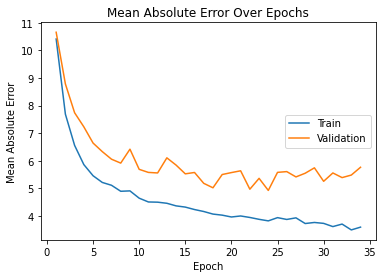

In [57]:
plt.plot(range(1,len(history11.history['loss']) + 1), history11.history['loss'])
plt.plot(range(1, len(history11.history['loss']) + 1) , history11.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [58]:
np.random.seed(0)
tf.random.set_seed(0)

model12 = keras.models.Sequential([
    keras.layers.SimpleRNN(500, input_shape=[None, 1]),
    keras.layers.Dense(1)
])

callback = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights = True, patience=10)

model12.compile(loss="mae", optimizer="adam")
history12 = model12.fit(X[:,:7], X[:,7], epochs=500, callbacks = [callback],
                    validation_data=(X[:,:8], X[:,8]))

Epoch 1/500
32/32 [==============================] - 2s 35ms/step - loss: 7.7887 - val_loss: 7.0104
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 5.3408 - val_loss: 6.3733
Epoch 3/500
32/32 [==============================] - 1s 28ms/step - loss: 5.1095 - val_loss: 6.0476
Epoch 4/500
32/32 [==============================] - 1s 28ms/step - loss: 4.7499 - val_loss: 5.4301
Epoch 5/500
32/32 [==============================] - 1s 28ms/step - loss: 4.7550 - val_loss: 6.4479
Epoch 6/500
32/32 [==============================] - 1s 28ms/step - loss: 4.7336 - val_loss: 5.9314
Epoch 7/500
32/32 [==============================] - 1s 28ms/step - loss: 4.5634 - val_loss: 5.5302
Epoch 8/500
32/32 [==============================] - 1s 28ms/step - loss: 4.3373 - val_loss: 5.2522
Epoch 9/500
32/32 [==============================] - 1s 30ms/step - loss: 4.5662 - val_loss: 5.4379
Epoch 10/500
32/32 [==============================] - 1s 36ms/step - loss: 4.2660 - val_loss: 4.9312

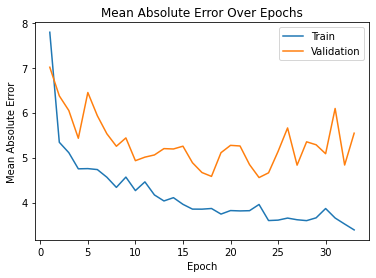

In [59]:
plt.plot(range(1,len(history12.history['loss']) + 1), history12.history['loss'])
plt.plot(range(1, len(history12.history['loss']) + 1) , history12.history['val_loss'])
plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Learning is a lot less stable in this second method as can be seen by the loss curves, especially in the models with 200 and 500 RNN units. Generalizing within sequences appears to be a more difficult task from earlier time-steps appears to be a more difficult task. 

As before models are compared with this new approach.

In [60]:
models = [model7, model8, model9, model10, model11, model12]
maes_train = []
maes_val = []

for model in models:
  preds_train = model.predict(X[:,:7])
  preds_val = model.predict(X[:,:8])
  maes_train.append(np.mean(abs(preds_train[:,0] - X[:,7])))
  maes_val.append(np.mean(abs(preds_val[:,0] - X[:,8])))

32/32 [==============================] - 0s 8ms/step


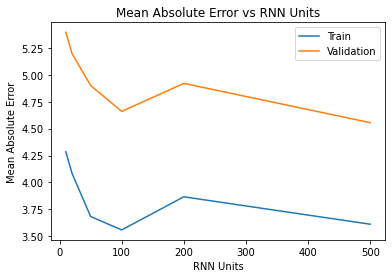

In [62]:
units = [10,20,50,100,200,500]

plt.plot(units, maes_train)
plt.plot(units , maes_val)
plt.title('Mean Absolute Error vs RNN Units')
plt.ylabel('Mean Absolute Error')
plt.xlabel('RNN Units')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [63]:
maes_val

[5.39624197781086,
 5.198551443815231,
 4.900987118303775,
 4.660602034717798,
 4.920650823712349,
 4.55588912153244]

|Units|Mean Absolute Error (Validation)|
|:----|:--------:|
|10|5.396|
|20|5.199|
|50|4.901|
|100|4.661|
|200|4.921|
|500|4.556|

The above table is to four significant figures. As with method 1, 500 units performs best on the validation set (which is distinct from the validation set in method 1) but the improvements from 100 to 500 units are minimal.

The best model based on above is now used to make inference on the test set constructed in (100 sequences randomly sampled from the 1000) method 1 for direct comparison of the two approaches.

In [64]:
preds = model12.predict(X_test)
np.mean(abs(preds[:,0] - y_test))

4/4 [==============================] - 0s 8ms/step


5.44399489402771

The loss for a benchmark model using the 9th sequence as the prediction for the 10th sequence value on the test set is also calculated below.

In [66]:
np.mean(abs(X_test[:,-1] - y_test))

5.27

# Results Summary

The below table summarizes the mean absolute error on the test set determined by the experimental procedure in method 1 (predicting 10th sequence value based on prior nine using the 100 sequences in the test split) to four significant figures. 


|Method|Mean Absolute Error (Test)|
|:----|:--------:|
|Benchmark|5.270|
|1|3.440|
|2|5.444|

 
 
Method 1 with the similar procedure on differing sequences performs best, whereas method 2 which uses all sequences but earlier parts of them performs worse than the benchmark (using 9th sequence value as prediction). 

In [65]:
np.mean(preds[:,0] - y_test)

1.9325928211212158

In [71]:
np.mean(X_test[:,-1] - y_test)

-2.65

The above calculations though illustrate that unlike the benchmark, this is due to on average over predicting versus the benchmark underpredicting. There is still "learning" taking place but generalizability to the 10th sequence value suffers in method 2 and fitting to the 10th sequence value in particular (as was the case in method 1) leads to better results.

 


# Conclusion

Two competing experimental design approaches were considered in determining how to best utilize recurrent neural networks (RNNs) in integer sequence learning using sequences from the Online Encyclopedia of Integer Sequence (OEIS). In particular, predicting specifically the tenth sequence value from the first nine can be achieved by fitting a model on different sequences at the corresponding sequence values or on the same sequences at earlier sequence values. Generalizability is better achieved using the former of these, meaning in this instance the fixed time-step under consideration potentially encodes usable information.
 
This is quite surprising for 1000 randomly sampled integer sequences from OEIS as OEIS draws from many unconnected branches of mathematics where beyond the culling of sequence values, there is no expectation of them being drawn from some joint distribution. Some limited structure was drawn from the selection process of the sequences (non-negative values not greater than 100).Initially the expectations were that for 1000 sequences, using all sequences in training would lead to better results with potentially this being reversed when the sample increased to 10000 (or more) sequences.  The work is limited by only considering only one sample and one seed for hyperparameter tuning the number of RNN units and repeating the process  across multiple samples and  fitting runs would give insights into the variance of these two procedures and statistical significance of one method being preferable.
 
Thus addressing the above limitation would be a natural extension of the work presented here. Considering larger samples and also a different time-step than the 10th sequence value would also provide intuition towards generalizability of the results. Furthermore,as mentioned earlier in the motivation for this work, connections to stock market prices at specific time-steps and occupancy booking curves in hotels or airlines. Seeing the competing procedures applied to real-world data sets in these use cases would also be worth exploring. 




# References
(Sloane, 1964) https://oeis.org/

(Bieber, 2020) https://davidbieber.com/snippets/2020-06-28-oeis-download/